# Fun with MNIST

**IMPORTANT INFO:** This Lab is quite long. I expect you to be able to complete up and until Task 3.1 during the exercise class (TØ). The remaining part of the lab serves to demonstrate some of all the cool things convolutions neural networks can do. I strongly recommend that you try to solve as many of the tasks as possble on your own - and afterwards watch the recording of my solution once that it has been released.

Convolutional Neural Networks (CNNs) are able to solve a wide range of computer vision tasks. In this Lab you will learn about

- Image classification
- Convolutional AutoEncoders
- Denoising AutoEncoders
- Image super resolution
- Image regression
- Image segmentation
- Object detection
- Few-shot learning with Siamese networks
- Generative Adversarial Networks (GANs)

The purpose of the Lab is to give your some intuition about how to tweak CNNs to solve different tasks.

**Before we start - remember to set runtime to GPU**

## Task 1: Downloading and pre-processing the MNIST dataset
The MNIST dataset of handwritten digits is so commonly used that it comes with most deep learning frameworks, including Keras. Let's download the dataset and explore a little bit.

[5 0 4 ... 5 6 8]
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
Examples of test images


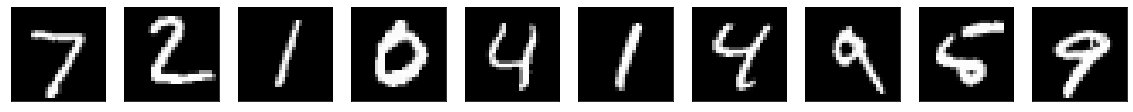

In [4]:
from __future__ import print_function
import tensorflow
from tensorflow import keras
from keras.datasets import mnist
from keras import backend as K
from matplotlib import pyplot as plt

# Utility function for showing images
def show_imgs(x_test, n=10):
    sz = x_test.shape[1]
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(sz,sz))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Pre-process inputs
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class indices to one-hot vectors
print(y_train)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_train)

print('Examples of test images')
show_imgs(x_test)

### Questions 1.1
1. What is the input shape? 28x28x1
2. How many training examples are there? 60k
3. How many test examples are there? 10k
4. What does `to_categorical` do? (Hint: print `y_test` before and after applying `to_categorial`). It turns the training vector into a one-hot-encoding.

In [3]:
print(x_train.shape)
print(len(x_train))
print(len(x_test))

(60000, 28, 28, 1)
60000
10000


## Task 2: Softmax regression
Now, let's define a tiny Keras model for logistic regression. Mathematically this model outputs a 10-dimensional vector `y` of class probabilities, where


```
y = softmax(W*x + b)
```

and
- `x` is a 28x28 = 784-dimensional vector corresponding to the input image, 
- `W` is a 10 x 784 matrix of weights
- `b` is a 10-dimensional vector of biases

Defining models in Keras is not very intuitive from a mathematical perspective. Here is one way to implement the equation above using Keras' [Sequential API](https://keras.io/getting-started/sequential-model-guide/). A Sequential model is a just a linear stack of layers.

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation

tensorflow.random.set_seed(0) # make weight initialization deterministic

# Model
model = Sequential()
model.add(Flatten(input_shape=input_shape)) # input_shape is (28, 28, 1)
model.add(Dense(num_classes)) # num_classes is 10
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


### Questions 2.1
1. What do you think the Flatten() layer does, and why is it necessary to have it here?
The flatten layer flattens the input, therefore transforming a tensor into a vector. It is necessary to perform classification, once the feature extraction has been executed. 
2. What do you think the Dense() layer does, and why does it have 7850 parameters? It creates a densely-connected layer. It has 10x784 + 10 = 7850 parameters, matching the shapes of W and b. The Dense layer performs the `W*x+b` part of the logistic regression equation. 
3. What do you think Activation() does, and why is its argument set to "softmax"?  The Activation layer performs the softmax operation by converting the scores `W*x+b` into probabilities.

**Tip**

To answer questions like the ones above, you could perform simple experiments like the one below:

```
input_shape = (28, 28, 1)
x = tensorflow.random.normal(input_shape)
y = keras.layers.Flatten()(x)
print(y.shape)
```

### Training

Now, let's train the model for 10 epochs. We will be using the multi-class version of the cross entropy loss and stochastic gradient descent (SGD). The difference between normal gradient descent and SGD is that normal gradient descent calculates the gradients based on all training examples, whereas SGD approximates the gradient by calculating it on small batches (of size 128 in this example).

In [6]:
batch_size = 128
epochs = 10

# Compile the model before training
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

# Fit model
history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Epoch 1/10
469/469 [==============================] - 4s 3ms/step - loss: 1.2596 - accuracy: 0.6956 - val_loss: 0.8108 - val_accuracy: 0.8319
Epoch 2/10
469/469 [==============================] - 1s 3ms/step - loss: 0.7155 - accuracy: 0.8376 - val_loss: 0.6079 - val_accuracy: 0.8601
Epoch 3/10
469/469 [==============================] - 2s 3ms/step - loss: 0.5869 - accuracy: 0.8583 - val_loss: 0.5259 - val_accuracy: 0.8729
Epoch 4/10
469/469 [==============================] - 1s 3ms/step - loss: 0.5248 - accuracy: 0.8681 - val_loss: 0.4802 - val_accuracy: 0.8815
Epoch 5/10
469/469 [==============================] - 1s 3ms/step - loss: 0.4872 - accuracy: 0.8755 - val_loss: 0.4501 - val_accuracy: 0.8865
Epoch 6/10
469/469 [==============================] - 1s 3ms/step - loss: 0.4612 - accuracy: 0.8805 - val_loss: 0.4288 - val_accuracy: 0.8894
Epoch 7/10
469/469 [==============================] - 1s 3ms/step - loss: 0.4420 - accuracy: 0.8836 - val_loss: 0.4126 - val_accuracy: 0.8924
Epoch 

In machine learning it is always a good idea to pick a simple **baseline model** that you can compare your own models to. We will refer to the classifier above as our baseline. You should expect the validation accuracy of our baseline model to be around 90% after training for 10 epochs.

### Model evaluation
For several reasons you always want to monitor how your model performs during training. The simplest way to monitor the training process is by plotting the loss and accuracy curves. Here we are doing it post-training, but there are tools that allow you to monitor the curves in real-time (see for instance [TensorBoard](https://www.tensorflow.org/tensorboard)).

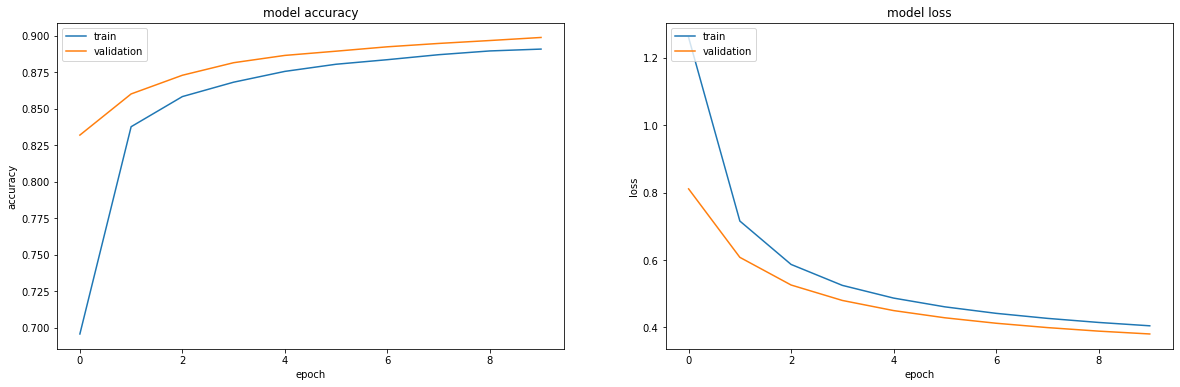

In [7]:
import matplotlib.pyplot as plt

def show_history(history):
  plt.figure(figsize=(20,6))

  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

show_history(history)

Examples of things you should be looking for:

- The loss should go down over time.
 - If it increases, it usually means that your learning rate was set too high.
 - If it doesn't decrease, it could indicate that your learning rate was set too low.
- If the validation loss starts increasing, while the training loss is still decreasing, it means that your model has started overfitting.
 - Can you explain why?
- Simply stated, your model is done training when the loss curves hit a low plateau.
 - Are we done training in the above example, or do you think we should we be training for more epochs?


### Task 2.1: Batch size and number of epochs
Training on the entire MNIST training data set is guaranteed to work (almost) always. Simply because of the large number of images in the training set. This is boring. So let's make our problem a little more challenging by reducing the number of training examples to just 10 samples from each class. 

In [8]:
import numpy as np

np.random.seed(0) # make it deterministic

# create smaller training set
digit_indices = np.asarray([np.where(np.argmax(y_train,axis=1) == i)[0][np.random.randint(0,5000,10)] for i in range(num_classes)]).flatten()
x_train_small = x_train[digit_indices,:]
y_train_small = y_train[digit_indices,:]

--- training tool 81.7082109451294 seconds ---
Validation loss: 1.0178085565567017
Validation accuracy: 0.7207000255584717


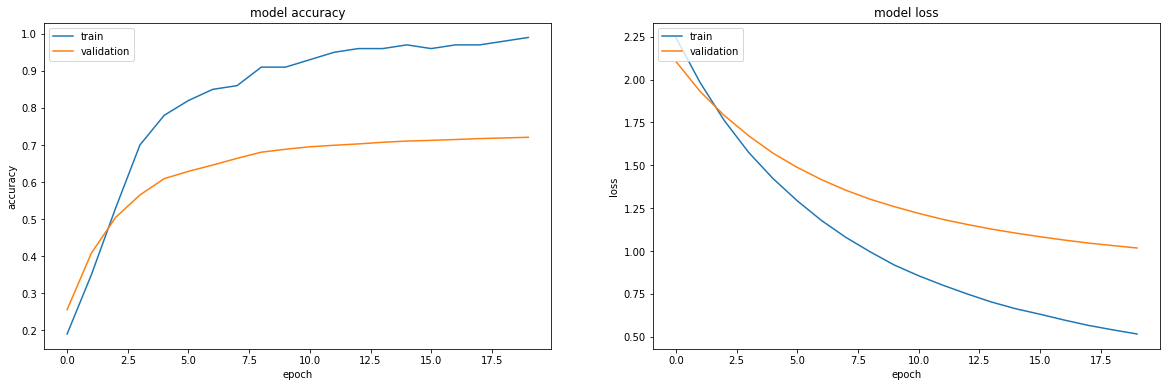

In [10]:
import time

batch_size = 5 # Cannot use 128 like before, because we only have 100 samples (10 from each class)
epochs = 20 # We need more epochs because we have fewer training samples

tensorflow.random.set_seed(0)

# Model (redefine the model in order to reinitialize the weights to random values)
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Compile the model before training
model.compile(optimizer=keras.optimizers.SGD(),loss='categorical_crossentropy',metrics=['accuracy'])

# Fit model (this will take a little while. Set verbose to 1 if you want to see how training progresses)
start_time = time.time()
history = model.fit(x_train_small, y_train_small,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test),
            verbose=0,
            shuffle=True)
print("--- training tool %s seconds ---" % (time.time() - start_time))

score = model.evaluate(x_test, y_test, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

# Plot old vs new loss
show_history(history)

**Note:** Although we didn't change the underlying equation of our baseline model (`y = softmax(Wx+b)`), we did change the nature of the data on which the model was trained, and we also lowered the batch size and increased the number of epochs. So this is considered a **new model** that we could compare to our baseline model.

### Question 2.2
1. Our new model performs worse than the baseline model. Why? We have a much smaller training dataset
2. This puzzle is supposed to make you speculate. You are not required to get the answers right at this stage of the course. Temporarily set the number of epochs to 10 to make experimentation faster. How does training behave when we set the batch size to the values listed below? Compare the loss curves and the training times and see if you can figure out why they differ the way they do. Use these batch sizes:
 - 1 (lowest possible)
 - 5 (low)
 - 20 (medium)
 - 100 (highest possible)

**Advantages** of using a small batch size: Requires less memory since you are training using less samples each iteration; Typically networks learn faster (in a smaller # of epochs) with mini-batches since the weights are updated more often. **Disadvantages**: The smaller the batch the less accurate the estimate of the gradient will be. Processing smaller batches might add up some computational overhead to your training procedure, depending on the hardware.
See more: https://arxiv.org/abs/1804.07612
3. Above, we changed the batch size and the number of epochs. Are these *hyperparameters* or *learnable parameters*? Btw., what are the learnable parameters of our model (``y = softmax(W*x + b)``)?
They are hyperparameters. The learnable parameters are the weights and the biases.
4. Which criteria would you pick to determine the "optimal" combination of batch size and number of epochs?


**IMPORTANT:** Before continuing to the next task, retrain the model above using a batch size of 5 and number of epochs set to 20.

### Task 2.2: Finding a better learning rate
The learning rate is another hyperparameter that we can tweak.

Training with the default learning rate (which is 0.01) is rather slow. Your task is to find a better learning rate that makes the model converge faster, without comprimising the model's accuracy on the validation set. With a proper learning rate you should be able to achieve 74-75% accuracy in just 10 epochs (instead of 20 as above).

You can adjust the learning rate by setting the `learning_rate` argument of keras.optimizer.SGD:

```
keras.optimizers.SGD(learning_rate=0.01)
```

**Optional bonus question:** What happens if you set the learning rate way too low (e.g. 0.0001)?


### Task 2.3: Displaying the learned weights
In the case of softmax regression there is a very intuitive interpretation of the learned weights of the coefficient matrix `W`, as you will see below.

First, your task is to extract the weights of the coefficient matrix from the model (i.e. the `Dense` layer) and display each row as an image.

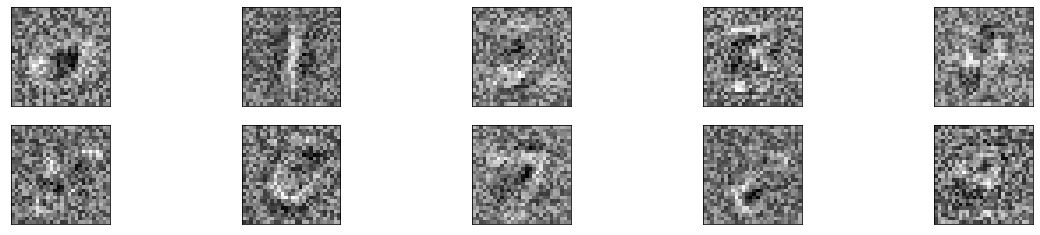

In [11]:
layer = model.layers[1]
W = layer.get_weights()[0]
W = W.reshape((28,28,10)) # there are 10 classes and one 28x28 weight image per class
plt.figure(figsize=(20,4))
for i in range(10):
  ax = plt.subplot(2,5,i+1)
  plt.imshow(W[:,:,i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.gray()

### Questions 2.3
1. How do we interpret the weights?
2. In some regions the weights are very noisy. What could be the consequences of that?

1. `W` has one row per class (shape 10x784). The product `Wx` outputs a 10x1 vector, where the i'th element is the inner product between input `x` and the i'th row of `W`. Recall that the inner product is a kind of similarity measure. Hence, the rows of `W` act as a kind of "templates" - one for each digit - that we compare the input against. Which ever template matches best with `x` is going to determine which class the model predicts for `x`.
2. The noisy regions at the borders of the weight images correspond to portions where we have no training data (because the input image intensities tend to be close to 0 near the borders). It is undefined how the model behaves if it actually sees data in these noisy regions. A consequence of this could be that if you input a noisy test image, the model's prediction is going to be incorrect. In other words, the noise in the weights may hamper the ability of the model to generalize to unseen data. This is called overfitting...

### Task 2.4: Weight decay (or L2 regularization)
With only 10 observations per class in our training data set, it is very likely that our model overfits the training data. This leads to poor generalization (i.e., the model doesn't work that well on unseen data).

One way to address overfitting is by means of regularization. The best kind of regularization is "adding more data" (of course). This is the reason that our baseline model performs better than the current model.

One possible regularization strategy is to use *weight decay*. So let's modify the loss function of the model by adding an L2 regularization term. The regularization term is added using an extra parameter to the Dense layer.

Please note that the weight of the penalty term (`lamda`) has been set rather high in the example below. As a consequence, you will actually see a small decrease in validation accuracy. But as you will see later, weight decay has dramatic effect on the learned weights (`W`). By the way, `lambda` is yet another hyperparameter that we could tweak to make our model perform better.

Validation loss: 1.6381233930587769
Validation accuracy: 0.7016000151634216
Loss curves with regularization


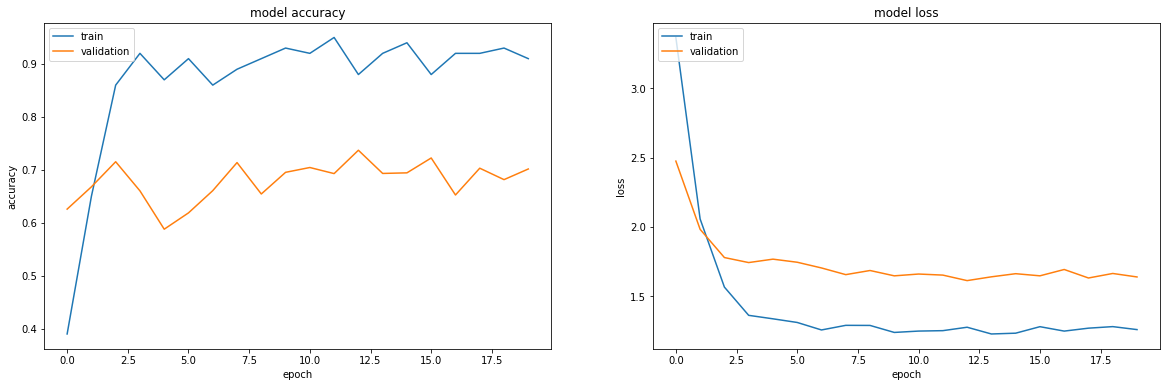

In [12]:
batch_size = 5
epochs = 20

tensorflow.random.set_seed(0)

# lamda is the weight of the L2 penalty term
lamda = 0.1
L2_regularizer = keras.regularizers.l2(lamda)

# Model
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(num_classes,
                activation='softmax',
                kernel_regularizer=L2_regularizer))

# Training
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.1),loss='categorical_crossentropy',metrics=['accuracy'])
history_reg = model.fit(x_train_small, y_train_small,
            batch_size=batch_size,
            epochs=epochs,
            verbose=0,
            validation_data=(x_test, y_test))

# Evaluation
score = model.evaluate(x_test, y_test, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

# Plot loss
print("Loss curves with regularization")
show_history(history_reg)

**Now comes the interesting part:** Try once more to display the weights - this time of the regularized model.

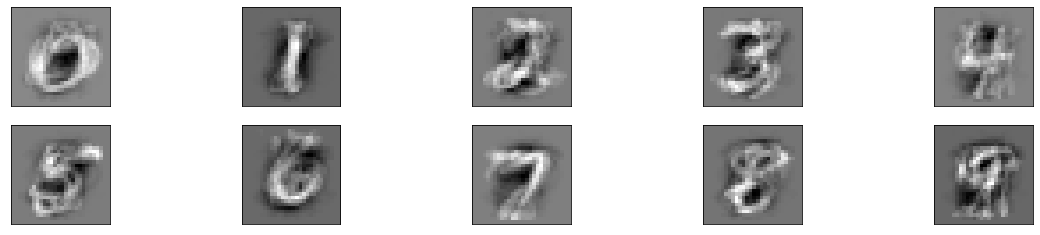

In [13]:
layer = model.layers[1]
W = layer.get_weights()[0]
W = W.reshape((28,28,10))
plt.figure(figsize=(20,4))
for i in range(10):
  ax = plt.subplot(2,5,i+1)
  plt.imshow(W[:,:,i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.gray()

### Questions 2.4
1. How do the weights of the regularized model differ from the weights of the non-regularized model?
2. Can you explain why?

1. They are far less noisy
2. Adding the L2 penalty makes the model prefer smaller weights, eventually forcing non-used weights towards zero. In general, this reduces the chances of overfitting the training data.

### Functional API instead of Sequential API
The models above have been specified using Keras' [Sequential API](https://keras.io/getting-started/sequential-model-guide/). Keras also allows you to specify models using the [Functional API](https://keras.io/getting-started/functional-api-guide/). The Keras functional API is the way to go for defining complex models, such as multi-output models, directed acyclic graphs, or models with shared layers.

Here is how to set up the (baseline) softmax regression model using the functional API:

In [14]:
from keras.layers import Input
from keras.models import Model

tensorflow.random.set_seed(0)

# This returns a tensor
inputs = Input(shape=input_shape)

# A layer instance is callable on a tensor, and returns a tensor
x = Flatten()(inputs)
x = Dense(num_classes)(x)
predictions = Activation('softmax')(x)

# This creates a model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

# Training
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))

# Evaluation
score = model.evaluate(x_test, y_test, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Epoch 1/10
469/469 [==============================] - 2s 3ms/step - loss: 1.2596 - accuracy: 0.6956 - val_loss: 0.8108 - val_accuracy: 0.8319
Epoch 2/10
469/469 [==============================] - 1s 3ms/step - loss: 0.7155 - accuracy: 0.8376 - val_loss: 0.6079 - val_accuracy: 0.8601
Epoch 3/10
469/469 [==============================] - 1s 3ms/step - loss: 0.5869 - accuracy: 0.8583 - val_loss: 0.5259 - val_accuracy: 0.8729
Epoch 4/10
469/469 [==============================] - 1s 3ms/step - loss: 0.5248 - accuracy: 0.8681 - val_loss: 0.4802 - val_accuracy: 0.8815
Epoch 5/10
469/469 [==============================] - 1s 3ms/step - loss: 0.4872 - accuracy: 0.8755 - val_loss: 0.4501 - val_accuracy: 0.8865
Epoch 6/10
469/469 [==============================] - 1s 3ms/step - loss: 0.4612 - accuracy: 0.8805 - val_loss: 0.4288 - val_accuracy: 0.8894
Epoch 7/10
469/469 [==============================] - 1s 3ms/step - loss: 0.4420 - accuracy: 0.8836 - val_loss: 0.4126 - val_accuracy: 0.8924
Epoch 

## Task 3: Our first CNN
It's time to move on and build our first CNN.

Here is a simple example:

In [15]:
from keras.layers import Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input
from keras.models import Model

tensorflow.random.set_seed(0)

inputs = Input(shape=(28, 28, 1))

# Encoder (convolutional base)
x = Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
encoded = Flatten()(x)

# Decoder (2 fully connected layers)
x = Dense(units=64, activation='relu')(encoded)
x = Dropout(rate=0.5)(x)
predictions = Dense(units=num_classes,activation='softmax')(x)

# This creates a callable model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 32)          4640

### Questions 3.1
1. How many layers does this CNN have? 
It has 10 layers of which 9 are actually computing something (Flatten layer just vectorizes). In comparison, the softmax regression model had only 1 layer that computed something. More layers is in general better, which is why this CNN achieves higher accuracy.
2. How many convolution filters are there in the first convolution layer, and what is the width and height of the filters? 
8 filters, 3x3
3. What does the MaxPooling2D layer do?
MaxPooling2D is a way of downsampling the input (feature maps). It serves to throw away information that we assume we won't be needing anymore. For each 2x2 cell, max pooling simply transfers the maximum value (= the most important activation). Max pooling also helps us achieve some degree of translation invariance.
4. What does the Dropout layer do?
Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.
5. What is the shape of the input of the last convolution layer (i.e., just before the flatten layer)
3x3x32

**Recall**

You can make small experiments like this one

```
input_shape = (1, 28, 28, 1) # Dimensions are (batch_size, height, width, num_channels)
x = tensorflow.random.normal(input_shape)
y = keras.layers.Conv2D(filters=2, kernel_size=3, activation='relu', padding="same", input_shape=input_shape[1:])(x)
print(y.shape)
```

**Optional bonus task:** See if you can figure out a way to display the filters of the first convolution layer as images.

**Note:** The same model could also be defined using the sequential API:


```
from keras.layers import Dropout
from keras.layers import Conv2D ![alt text](https://), MaxPooling2D

input_img = Input(shape=(28, 28, 1))
model = Sequential()
model.add(Conv2D(8,
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16,
                 kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32,
                 kernel_size=(3, 3),
                 activation='relu'))
model.add(Flatten())
model.add(Dense(64,
                activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()
```



### Training
Let's train our model on the small dataset and evaluate it on the validation set:

In [16]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train_small, y_train_small,
                    batch_size=10,
                    epochs=30,
                    verbose=1,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Validation loss:', score[0])
print('Valdiation accuracy:', score[1])

Epoch 1/30
10/10 [==============================] - 12s 307ms/step - loss: 2.3098 - accuracy: 0.1400 - val_loss: 2.2840 - val_accuracy: 0.2446
Epoch 2/30
10/10 [==============================] - 2s 203ms/step - loss: 2.2945 - accuracy: 0.1000 - val_loss: 2.2572 - val_accuracy: 0.2942
Epoch 3/30
10/10 [==============================] - 2s 199ms/step - loss: 2.2495 - accuracy: 0.2100 - val_loss: 2.2108 - val_accuracy: 0.2710
Epoch 4/30
10/10 [==============================] - 2s 203ms/step - loss: 2.1733 - accuracy: 0.2300 - val_loss: 2.0999 - val_accuracy: 0.3593
Epoch 5/30
10/10 [==============================] - 3s 287ms/step - loss: 2.0484 - accuracy: 0.3600 - val_loss: 1.7844 - val_accuracy: 0.5231
Epoch 6/30
10/10 [==============================] - 2s 202ms/step - loss: 1.7706 - accuracy: 0.4100 - val_loss: 1.3870 - val_accuracy: 0.5846
Epoch 7/30
10/10 [==============================] - 2s 202ms/step - loss: 1.5301 - accuracy: 0.4700 - val_loss: 1.1501 - val_accuracy: 0.6476
Epoch

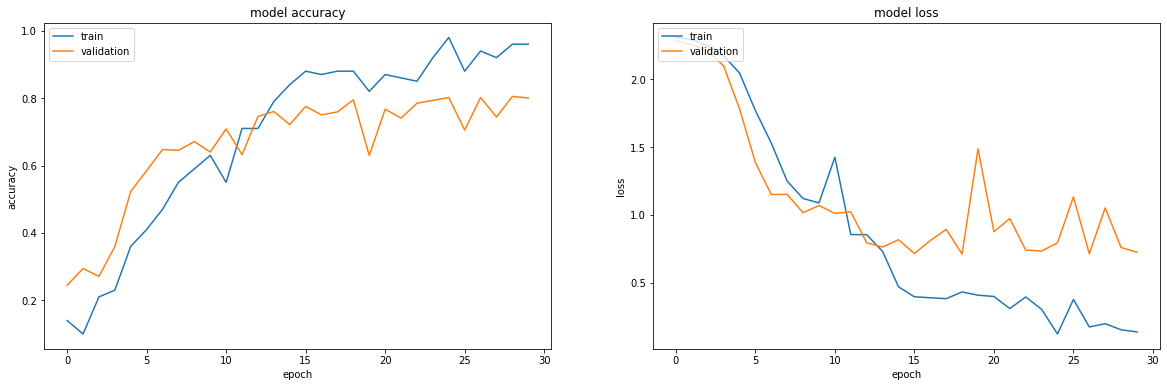

In [17]:
show_history(history)

Notice how this model is able to achieve a higher validation accuracy on the small training dataset (before we got 74.4%, now we have 80%). It does come at an expense, however; the CNN model needs to train for longer, having to do with the fact that it has more layers and more learnable parameters.

**Note:** If you train the above CNN model on the full MNIST dataset, you can expect to get at least 97-98% validation accuracy. That is quite an improvement over our baseline model (softmax regression), which got 89%.

### Task 3.1 Encoding the MNIST dataset in 2 dimensions with a CNN
In the above model the input shape to the Flatten layer  is 3x3x32, which is then flattened to a 288-dimensional vector, corresponding to the variable named `encoded`.

Your task is to modify the network such that variable `encoded` has dimensionality 2 instead of 288.

*Hint:* You could insert an extra layer before the Flatten layer that reduces the 3x3x32 input tensor to a 1x1x2 tensor. There are several solutions. It might be a good idea to add an activation function to the layer that you add. I used `activation='tanh'`. I will explain in the solution why this is a good idea.

In [20]:
from keras.layers import Dropout
from keras.layers import Conv2D, MaxPooling2D

tensorflow.random.set_seed(0)

inputs = Input(shape=(28, 28, 1))

# Encoder (convolutional base)
x = Conv2D(8, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
#I chose to add another convolution layer with 2 filters (and therefore 2 output channels). 
#Also, I set the activation function to ``tanh``, which will squash the values to the range -1 to 1. 
#This separates the classes better in 2D and makes the plot look nicer. You could also try with ``relu``, ``sigmoid`` or ``None``.
x = Conv2D(2, kernel_size=(3, 3), activation='tanh')(x) 
encoded = Flatten()(x)

# Decoder (2 fully connected layers)
x = Dense(64, activation='relu')(encoded)
x = Dropout(0.5)(x)
predictions = Dense(num_classes,activation='softmax')(x)

# This creates a callable model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 13, 8)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 16)        1168      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 32)          4640

### Training
This time we train the model on the full dataset, because compressing the images to 2 dimensions is a difficult task that requires more training data.

In [21]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=100,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
600/600 [==============================] - 3s 4ms/step - loss: 1.6374 - accuracy: 0.4004 - val_loss: 0.8871 - val_accuracy: 0.7154
Epoch 2/10
600/600 [==============================] - 2s 4ms/step - loss: 0.7671 - accuracy: 0.7425 - val_loss: 0.4404 - val_accuracy: 0.8828
Epoch 3/10
600/600 [==============================] - 2s 4ms/step - loss: 0.4585 - accuracy: 0.8758 - val_loss: 0.2589 - val_accuracy: 0.9381
Epoch 4/10
600/600 [==============================] - 2s 4ms/step - loss: 0.3471 - accuracy: 0.9126 - val_loss: 0.2005 - val_accuracy: 0.9554
Epoch 5/10
600/600 [==============================] - 2s 4ms/step - loss: 0.2957 - accuracy: 0.9273 - val_loss: 0.2277 - val_accuracy: 0.9442
Epoch 6/10
600/600 [==============================] - 2s 4ms/step - loss: 0.2596 - accuracy: 0.9373 - val_loss: 0.2007 - val_accuracy: 0.9557
Epoch 7/10
600/600 [==============================] - 2s 4ms/step - loss: 0.2353 - accuracy: 0.9439 - val_loss: 0.1982 - val_accuracy: 0.9515
Epoch 

### Task 3.2
Run all test examples (`x_test`) through your model and for each example extract the 2-dimensional vector output of the Flatten layer (variable named `encoded`). To make predictions on a batch of images, you can do like this: ``out = model_encoded.predict(batch)``.

Then plot those vectors in a 2D plot, where each class gets its own color.

You might find this code useful:

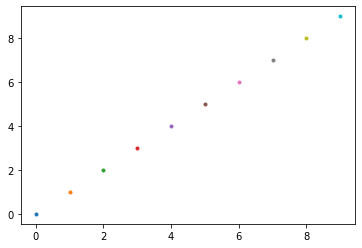

In [22]:
model_encoded = Model(inputs=model.input, outputs=encoded)

# Plot 10 dots with 10 different colors
for i in range(10):
  plt.plot(i,i,'.C'+str(i))

## Task 4: Convolutional Autoencoder
Autoencoders are special types of neural networks that map the input X to the same output (namely X). So the autoencoder (AE) is an identity function:

```
X = AE(X)
```

So what's the point? The point is that the autoencoder compresses the image down to a low-dimensional representation, which can be decoded again to reconstruct the original input image. This has many useful applications, such as data compression and representation learning. Only the important information is stored in the low-dimensional representation.

The autoencoder consists of a trained encoder (E) and a trained decoder (D):

```
X = AE(X) = D(E(X))
```

It is typically (but not always) the encoding E(X) that we are interested in.

Note that the autoecoder does not need the class labels to train. So it is an **unsupervised** machine learning technique.

Here is an example of a convolutional autoencoder:

In [ ]:
from keras.layers import UpSampling2D

tensorflow.random.set_seed(0)
inputs = Input(shape=(28, 28, 1))

# Encoder (convolutional base)
x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
print(("shape of encoded", K.int_shape(encoded)))

# Decoder (upsamling)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(x) 
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, kernel_size=(5, 5), padding='valid')(x)
print(("shape of decoded", K.int_shape(decoded)))

autoencoder = Model(inputs, decoded)
autoencoder.summary()

### Questions 4.1
1. What is the shape of the encoded image?
2. Why are we not flattening (i.e., vectorizing) the encoded image like we did in the CNN classifier above?
3. What does UpSampling2D do?
4. Why do you think upsampling is followed by a convolution? Hint: It has to do with the way we are upsampling...
5. See if you can figure out what `padding` means. What is the difference between using `padding='same'` and `padding='valid'`?

**Again** remember that you can carry out small experiments to get the answers.

### Training
Let's train the autoencoder:

In [ ]:
autoencoder.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), loss='mse')
autoencoder.fit(x_train, x_train, epochs=10, batch_size=100,
               shuffle=True, validation_data=(x_test, x_test), verbose=1)

And show some test results

In [ ]:
decoded_imgs = autoencoder.predict(x_test)
print("input (upper row)")
show_imgs(x_test)
print("decoded (bottom row)")
show_imgs(decoded_imgs)

### Improving the autoencoder
This is okay, but not great. Let's use binary cross entropy (BCE) loss instead of mean squared error (MSE) loss. Using BCE assumes that the inputs are a probabilities, hence the sigmoid below to squash the values in between 0 and 1.

In [ ]:
decoded_sigmoid = Activation('sigmoid')(decoded) # decoded is the output of the first autoencoder
autoencoder2 = Model(inputs, decoded_sigmoid)
autoencoder2.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), loss='binary_crossentropy')
autoencoder2.fit(x_train, x_train, epochs=10, batch_size=100,
               shuffle=True, validation_data=(x_test, x_test), verbose=1)

In [ ]:
decoded_imgs = autoencoder2.predict(x_test)
print("input (upper row)")
show_imgs(x_test)
print("decoded (bottom row)")
show_imgs(decoded_imgs)

### Questions 4.2
1. What is the difference between 'mse' loss and 'binary_crossentropy' loss?
2. Can you explain why 'binary_crossentropy' works better?

## Task 5: Denoising Autoencoder
Autoencoders can get really advanced, like [Variational Autoencoders](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf). A slightly less complicated, yet powerful autoecoder variant is the [Denoising Autoencoder](https://www.cs.toronto.edu/~larocheh/publications/icml-2008-denoising-autoencoders.pdf).

As stated above autoencoders have many useful applications. One of these is *noise reduction*. The underlying idea is very simple: Add random noise to the input X, and teach the autoencoder to remove the noise. That is, the autoencoder should learn the mapping:

```
X = AE(X + noise)
```

### Task 5.1
Create two new data sets based on x_train and x_test, where you have added noise such that

```
x_train_noisy = x_train + noise
x_test_noisy = x_test + noise
```

You may want to look at numpy functions like [np.random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html) and [np.clip](https://numpy.org/doc/stable/reference/generated/numpy.clip.html).

**Your tasks:**

1. Does ``autoencoder2`` work on the noisy images, ``x_test_noisy``? (test it!)
2. Retrain ``autoencoder2`` on the noisy images (input = ``x_train_noisy`` and output = ``x_train``). What do you observe?

How much noise can you add before the autoencoder breaks down (fails to remove the noise)?

In [ ]:
#Your code goes here
#x_train_noisy = ???
#x_test_noisy = ???

## Task 6: Super resolution
The convolutional autoencoder is a network that maps an image to another image. There are other types of these *image-to-image networks*.

One example is a super resolution network. This is pretty much an autoencoder, except that the input image has lower spatial resolution than the output image. Super resolution networks learn to increase the spatial of the input image.

Your task is to modify the autoencoder such that it takes an 14x14x1 image as input and transforms it to a 28x28x1 image. Specifically, the training and test inputs should be



Input low resolution images


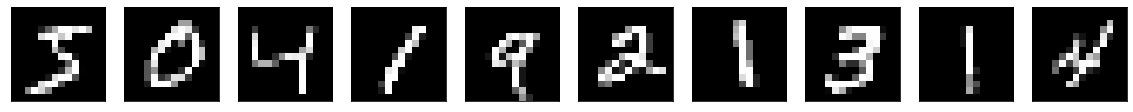

Output high resolution images (target)


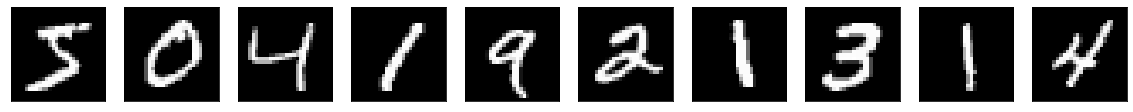

In [23]:
# Low resolution images (pick every other pixel)
x_train_lowres = x_train[:,::2,::2,:] # 14x14x1
x_test_lowres = x_test[:,::2,::2,:] # 14x14x1

# Show example
print("Input low resolution images")
show_imgs(x_train_lowres)
print("Output high resolution images (target)")
show_imgs(x_train)

## Task 7: Image regression
Recall that in a regression problems the output of the model is one or more scalar values, rather than class labels. Both the autoencoder and super resolution network are examples of regression models. Another example of image regression is [facial landmark prediction](https://medium.com/@rishiswethan.c.r/emotion-detection-using-facial-landmarks-and-deep-learning-b7f54fe551bf), which can be used for emotion recognition.

In this task we will estimate the rotation angle of rotated MNIST images (but it could just as well have been estimating pixel coordinates of facial landmarks).

As a first step, we need an image generator that generates batches of randomly rotated images, along with the target rotation angles that the model should learn to predict. This code was modified from https://d4nst.github.io/2017/01/12/image-orientation/

**Optional bonus task:** Writing your own custom data generators is a common task in deep learning. Once you have completed the main task, consider going through the code of  `RotNetDataGenerator` and see if you can figure out how it works (notice that its base class is [`keras.preprocessing.image.Iterator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/Iterator)).

In [ ]:
from keras.preprocessing.image import Iterator
from keras.utils.np_utils import to_categorical
import cv2

class RotNetDataGenerator(Iterator):

    def __init__(self, input, batch_size=64,
                 preprocess_func=None, shuffle=False):

        self.images = input
        self.batch_size = batch_size
        self.input_shape = self.images.shape[1:]
        self.preprocess_func = preprocess_func
        self.shuffle = shuffle

        # add dimension if the images are greyscale
        if len(self.input_shape) == 2:
            self.input_shape = self.input_shape + (1,)
        N = self.images.shape[0]

        super(RotNetDataGenerator, self).__init__(N, batch_size, shuffle, None)
        
    def _get_batches_of_transformed_samples(self, index_array):
        # create array to hold the images
        batch_x = np.zeros((len(index_array),) + self.input_shape, dtype='float32')
        # create array to hold the labels
        batch_y = np.zeros(len(index_array), dtype='float32')

        # iterate through the current batch
        for i, j in enumerate(index_array):
          
            image = self.images[j].squeeze()

            # get a random angle
            rotation_angle = np.random.randint(-30,30)

            # rotate the image
            rows,cols = image.shape
            M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),rotation_angle,1)
            rotated_image = cv2.warpAffine(image,M,(cols,rows))

            # add dimension to account for the channels if the image is greyscale
            if rotated_image.ndim == 2:
                rotated_image = np.expand_dims(rotated_image, axis=2)

            # store the image and label in their corresponding batches
            batch_x[i] = rotated_image
            batch_y[i] = rotation_angle

        # preprocess input images
        if self.preprocess_func:
            batch_x = self.preprocess_func(batch_x)

        return batch_x, batch_y

    def next(self):
        with self.lock:
            # get input data index and size of the current batch
            index_array = next(self.index_generator)
        # create array to hold the images
        return self._get_batches_of_transformed_samples(index_array)

### Test the generator

In [ ]:
# Instantiate
datagen = RotNetDataGenerator(
        x_train,
        batch_size=32,
        preprocess_func=None,
        shuffle=False
    )

# Generate batch
rotated_images, angles = datagen.next()

# Display
print("Images (before rotation)")
show_imgs(x_train)
print("Images after random rotation")
show_imgs(rotated_images)

### Task 7.1
Make a small CNN that takes as input an 28x28x1 image and outputs a single scalar value (the rotation angle).

The last layer of your network should be

```
angle = Dense(1)(x)
```

Note that this is a dense layer **without** any activation function, hence the output of this layer is simply `angle = W*x + b`.

In [ ]:
inputs = Input(shape=(28, 28, 1))

# Encoder (convolutional base)
# Your codes goes here

# Decoder (predict angle)
x = # Your code goes here
angle = Dense(1)(x)

angle_estimator = Model(input=inputs, output=angle)

### Training

In [ ]:
angle_estimator.compile(optimizer='rmsprop',loss='mse')

# training loop
angle_estimator.fit_generator(
    RotNetDataGenerator(
        x_train,
        batch_size=100,
        preprocess_func=None,
        shuffle=True
    ),
    epochs=50,
    validation_data=RotNetDataGenerator(
        x_test,
        batch_size=100,
        preprocess_func=None))

### Model evaluation

In [ ]:
# Set up generator
datagen = RotNetDataGenerator(
        x_test,
        batch_size=32,
        preprocess_func=None,
        shuffle=False
    )

# Generate test images
rotated_images, angles = datagen.next()
print("Test images before rotation")
show_imgs(x_test)
print("Test images after rotation")
show_imgs(rotated_images)

# Predict angles
angles_pred = angle_estimator.predict(rotated_images)

# Plot angles
print('Predicted vs. true rotation angles')
plt.plot(angles)
plt.plot(angles_pred)
plt.legend(['True','Predicted']);
plt.xlabel('Test image')
plt.ylabel('Rotation angle')

**HELP**: The predicted angles should match the true angles reasonably well. If your model fails to predict the angles, it could be because the model is underfitting. This indicates that the capacity of the model is too low. To increase capacity, add more connections in dense layers and/or more output maps in convolutional layers (I will explain this in the class).

### De-rotate images
Now that we have estimated the rotation angles, let's de-rotate the images back to their original alignment.

In [ ]:
de_rotated_images = np.zeros(rotated_images.shape)

for i in range(rotated_images.shape[0]):
  image = rotated_images[i,:,:,:].squeeze()

  # get predicted angle
  rotation_angle = -angles_pred[i]

  # rotate the image
  rows,cols = image.shape
  M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),rotation_angle,1)
  de_rotated_image = cv2.warpAffine(image,M,(cols,rows))

  de_rotated_images[i,:,:,0] = de_rotated_image

print('Images before rotation (ground truth)')
show_imgs(x_test)
print('Images after rotation (to be de-rotated)')
show_imgs(rotated_images)
print('De-rotated images (should match ground truth)')
show_imgs(de_rotated_images)

##Task 8: Object detection
**Motivation:** Classification CNNs assign one label to each input image. This is problematic if the image contains multiple objects. 

Object detection is about detecting and classifying multiple objects in images. Object detection networks output the corner coordinates of the bounding box of each detect object, along with a class label.

There are many ways to implement object detection with CNNs. At some point you may want to take a look at this 3-part tutorial:
- https://towardsdatascience.com/beginners-guide-to-object-detection-algorithms-6620fb31c375
- https://www.analyticsvidhya.com/blog/2018/11/implementation-faster-r-cnn-python-object-detection/?utm_source=blog&utm_medium=a-step-by-step-introduction-to-the-basic-object-detection-algorithms-part-1
- https://www.analyticsvidhya.com/blog/2018/12/practical-guide-object-detection-yolo-framewor-python/?utm_source=blog&utm_medium=implementation-faster-r-cnn-python-object-detection

The basic idea of our simple object detector below is as follows:

- The output image is divided into a 2-by-2 grid
- Each grid cell can contain one object, or no object. We want our model to output whether it thinks there is an object in the cell or not.
- If a cell contains an object, we want our model to output the corner coordinates of the bounding box (relative to the center of the grid cell).
- Also, if there is an object in a cell, we want to predict its class label.

If the input image has shape 64x64, the output of the model will have shape 2x2x15:
- 1 output per cell for the confidence (is there an object or not?)
- 4 outputs per cell corresponding to the upper left and lower right coordinates of the bounding box
- 10 outputs per cell corresponding to the class probabalities (assuming we have 10 classes).

This totals 15 outputs per cell.


###Comment
The network architecture below is somewhat inspired by YOLO:

![alt text](https://miro.medium.com/max/1152/1*m8p5lhWdFDdapEFa2zUtIA.jpeg)

### Task 8.1
Fill in the empty slots below (marked with ???), then run the code block to set up the object detection network.

In [ ]:
from keras.layers import concatenate
from keras.activations import softmax

def softMaxAxis3(x):
    return softmax(x,axis=3)

input_img = Input(shape=(64, 64, 1))

# Shared encoder
x = Conv2D(8, 33, activation='relu', padding='same')(input_img) #nb_filter, nb_row, nb_col
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, 3, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Notice that all three outputs use the same (shared) encoder

# 1. This predicts whether there is an object in a cell or not
x = Conv2D(4, 3, activation='relu', padding='same')(encoded)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, 3, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
confidence = Conv2D(???, 1, activation='sigmoid', padding='same')(x)

# 2. This predicts the bounding box coordinates for each cell
x = Conv2D(4, 3, activation='relu', padding='same')(encoded)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, 3, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
box = Conv2D(???, 1, padding='same')(x)

# 3. This predicts the class probabilities for each cell
x = Conv2D(16, 3, activation='relu', padding='same')(encoded)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, 3, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
classes = Conv2D(???, 1, activation=softMaxAxis3, padding='same')(x)

# Merge output
merged = concatenate([confidence, box, classes])

objdet = Model(input_img, merged)
objdet.compile(optimizer='rmsprop', loss='mse')

### Quesions 8.1
1. What does softMaxAxis3 do, and why is it needed?

### Training data
Let's generate some training data for our object detector.

The training images (`x_train_obj`) will be 64x64, where two of the four quadrants will contain one handwritten digit. This just serves to illustrate that we can teach a network to detect and classify more than one digit per input image.

The output is (`y_train_obj`) is 2x2x15 as explained above:
- 1 output per cell for the confidence (is there an object or not?)
- 4 outputs per cell corresponding to the upper left and lower right coordinates of the bounding box
- 10 outputs per cell corresponding to the class probabalities (assuming we have 10 classes).


In [ ]:
x_train_obj = np.zeros((5000,64,64,1))
y_train_obj = np.zeros((5000,2,2,15))

for i in range(5000):
  
  ## 1 
  q = np.random.randint(0,2) # 1st or 2nd image quadrant?
  
  # Random image
  rand_ix = np.random.randint(0,x_train.shape[0])
  x_off_start = np.random.randint(0,5)
  y_off_start = np.random.randint(0,5)
  x_train_obj[i,0+x_off_start:28+x_off_start,32*q+y_off_start:32*q+28+y_off_start,:] = x_train[rand_ix,:,:,:]
  
  # Set confidence to 1
  y_train_obj[i,0,q,0] = 1

  # Class label
  label = np.argmax(y_train[rand_ix,:])
  y_train_obj[i,0,q,5+label] = 1

  # Bounding box corners coordinates
  tmp = x_train[rand_ix,:,:,:]
  ix = np.where(tmp>0.1)
  rows = ix[0]
  cols = ix[1]  
  y_train_obj[i,0,q,1] = np.min(rows) + x_off_start
  y_train_obj[i,0,q,2] = np.min(cols) + y_off_start
  y_train_obj[i,0,q,3] = np.max(rows) + x_off_start
  y_train_obj[i,0,q,4] = np.max(cols) + y_off_start

  ## 2
  q = np.random.randint(0,2) # 3rd or 4rd image quadrant?
  
  # Random image
  rand_ix = np.random.randint(0,x_train.shape[0])
  x_off_start = np.random.randint(0,5)
  y_off_start = np.random.randint(0,5)
  x_train_obj[i,32+x_off_start:32+28+x_off_start,32*q+y_off_start:32*q+28+y_off_start,:] = x_train[rand_ix,:,:,:]
  
  # Set confidence to 1
  y_train_obj[i,1,q,0] = 1

  # Class label
  label = np.argmax(y_train[rand_ix,:])
  y_train_obj[i,1,q,5+label] = 1

  # Bounding box corners coordinates
  tmp = x_train[rand_ix,:,:,:]
  ix = np.where(tmp>0.1)
  rows = ix[0]
  cols = ix[1]  
  y_train_obj[i,1,q,1] = np.min(rows) + x_off_start
  y_train_obj[i,1,q,2] = np.min(cols) + y_off_start
  y_train_obj[i,1,q,3] = np.max(rows) + x_off_start
  y_train_obj[i,1,q,4] = np.max(cols) + y_off_start

Display example outputs

In [ ]:
import cv2
plt.figure(figsize=(20,4))
for k in range(10):
  result = np.tile(x_train_obj[k,:,:,:],(1,1,3))

  for i in range(2):
    for j in range(2):
      object_present = np.round(y_train_obj[k,i,j,0])
      if object_present:
        class_index = np.argmax(y_train_obj[k,i,j,5:])
        xmin = int(y_train_obj[k,i,j,1] + i*32) # row
        ymin = int(y_train_obj[k,i,j,2] + j*32) # col
        xmax = int(y_train_obj[k,i,j,3] + i*32) # row
        ymax = int(y_train_obj[k,i,j,4] + j*32) # col
        cv2.rectangle(result,(ymin,xmin),(ymax,xmax),(0,1,0),1)
        cv2.putText(result, str(class_index), (ymin-10, xmin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 1, 0),lineType=cv2.LINE_AA)
  ax = plt.subplot(2,5,k+1)
  plt.imshow(result)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

### Training
We are ready to start training the model.

In [ ]:
objdet.fit(x_train_obj, y_train_obj, epochs=100, batch_size=128,shuffle=True,verbose=1)

### Model evaluation

In [ ]:
out = objdet.predict(x_train_obj[0:10,:,:,:])

plt.figure(figsize=(20,4))
for k in range(10):
  result = np.tile(x_train_obj[k,:,:,:],(1,1,3))

  for i in range(2):
    for j in range(2):
      object_present = np.round(out[k,i,j,0])
      if object_present:
        class_index = np.argmax(out[k,i,j,5:])
        xmin = int(out[k,i,j,1] + i*32) # row
        ymin = int(out[k,i,j,2] + j*32) # col
        xmax = int(out[k,i,j,3] + i*32) # row
        ymax = int(out[k,i,j,4] + j*32) # col
        cv2.rectangle(result,(ymin,xmin),(ymax,xmax),(0,1,0),1)
        cv2.putText(result, str(class_index), (ymin-10, xmin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 1, 0),lineType=cv2.LINE_AA)
  ax = plt.subplot(2,5,k+1)
  plt.imshow(result)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

**Note:** Do not expect perfect results. Our object detection network is over-simplified compared to state-of-the-art. Or more precisely, the loss function is far from ideal, so we are optimizing *the wrong objective*, so to say.

## Task 9: Image segmentation
Image segmentation is a form of image-to-image transformation. It outputs a softmax classification per pixel. So if the input image has size 64x64, and there are 10 classes, the output will have shape 64x64x10. That is, for each pixel the network outputs a vector of class probabilities:

![alt text](https://miro.medium.com/max/498/1*P1ooLjeSwhxeJGyFawCvaQ.png)

Source of inspiration: https://medium.com/100-shades-of-machine-learning/https-medium-com-100-shades-of-machine-learning-rediscovering-semantic-segmentation-part1-83e1462e0805

Let's first make a new training set.

### Training images
The training images (x_train_seg) will be 64x64, where two of the four quadrants will contain one handwritten digit. This is to illustrate that we can teach a network to identify and segment more than one digit per input image.

The target output (`y_train_seg`) will be 64x64x10, with a one-hot vector for each pixel indicating the correct class.

In [ ]:
x_train_seg = np.zeros((5000,64,64,1))
y_train_seg = np.zeros((5000,64,64,10))

for i in range(5000):
  
  ## 1
  q = np.random.randint(0,2) # 1st or 2nd image quadrant?
  rand_ix = np.random.randint(0,x_train.shape[0])
  x_off_start = np.random.randint(0,5)
  y_off_start = np.random.randint(0,5)
  x_train_seg[i,0+x_off_start:28+x_off_start,32*q+y_off_start:32*q+28+y_off_start,:] = x_train[rand_ix,:,:,:]

  # Mask
  tmp = x_train[rand_ix,:,:,:]
  ix = np.where(tmp>0.1)
  tmp = np.zeros(tmp.shape)
  tmp[ix] = 1
  label = np.argmax(y_train[rand_ix,:])
  y_train_seg[i,0+x_off_start:28+x_off_start,32*q+y_off_start:32*q+28+y_off_start,label] = tmp.squeeze()
  
  ## 2
  q = np.random.randint(0,2) #  3rd or 4th image quadrant?
  rand_ix = np.random.randint(0,x_train.shape[0])
  x_off_start = np.random.randint(0,5)
  y_off_start = np.random.randint(0,5)
  x_train_seg[i,32+x_off_start:32+28+x_off_start,32*q+y_off_start:32*q+28+y_off_start,:] = x_train[rand_ix,:,:,:]

  # Mask
  tmp = x_train[rand_ix,:,:,:]
  ix = np.where(tmp>0.1)
  tmp = np.zeros(tmp.shape)
  tmp[ix] = 1
  label = np.argmax(y_train[rand_ix,:])
  y_train_seg[i,32+x_off_start:32+28+x_off_start,32*q+y_off_start:32*q+28+y_off_start,label] = tmp.squeeze()

In [ ]:
# Show examples of input to output mappings
for ex in range(5):
  plt.figure(figsize=(20,6))
  rand_ix = np.random.randint(0,5000)
  ax = plt.subplot(1,11,1)
  plt.imshow(x_train_seg[rand_ix,:,:,:].squeeze())
  plt.gray()
  plt.title('Input image')
  for i in range(10):
    ax = plt.subplot(1,11,i+2)
    plt.imshow(y_train_seg[rand_ix,:,:,i].squeeze())
    plt.gray()
    plt.title("Out class "+str(i))

### U-Net for image segmentation
We will use a light version of the so-called U-Net:
- https://arxiv.org/pdf/1505.04597.pdf
- https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47

![alt text](https://miro.medium.com/max/720/1*OkUrpDD6I0FpugA_bbYBJQ.png)

In [ ]:
from keras.layers import concatenate, BatchNormalization

# See last layer of network
def softMaxAxis3(x):
    return softmax(x,axis=3)

def my_conv(x,filters,kernel_size=3,padding='same',kernel_initializer='he_normal'):
  x = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

inputs = Input(shape=(64, 64, 1))

# Encoder
conv1 = my_conv(inputs,filters=8)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = my_conv(pool1,filters=16)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = my_conv(pool2,filters=32)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = my_conv(pool3,filters=64)

# Decoder
up7 = my_conv(conv4,filters=32)
up7 = UpSampling2D(size = (2,2))(up7)
merge7 = concatenate([conv3,up7], axis = 3)
up8 = my_conv(merge7,filters=16)
up8 = UpSampling2D(size = (2,2))(up8)
merge8 = concatenate([conv2,up8], axis = 3)
up9 = my_conv(merge8,filters=8)
up9 = UpSampling2D(size = (2,2))(up9)
merge9 = concatenate([conv1,up9], axis = 3)

# Perform softmax on each pixel, so axis should be 3 because output has shape: batch_size x 64 x 64 x num_classes
conv11 = Conv2D(num_classes, 1, activation = softMaxAxis3)(merge9)

model = Model(inputs, conv11)
model.summary()
model.compile(optimizer = keras.optimizers.RMSprop(learning_rate = 0.01), loss = 'mse')

### Questions 9.1
1. What does "concatenate" do?
2. Which pairs of layers of the encoder and decoder are being concatenated?
3. Why do you think U-Net concatenates outputs from layers of the encoder and layers of the decoder?

Hint: Use K.int_shape(...) to get the shapes of the layers that are being concatenated

### Training

In [ ]:
model.fit(x_train_seg, y_train_seg, epochs=20, batch_size=64, shuffle=True, verbose=1)

### Model evaluation

In [ ]:
# Pick 4 random examples
rand_ix = np.random.randint(0,5000,4)
out = model.predict(x_train_seg[rand_ix,:,:,:])
ref = y_train_seg[rand_ix,:,:,:].squeeze()
for k in range(4):
  plt.figure(figsize=(20,4))
  plt.subplot(2,11,1)
  plt.imshow(x_train_seg[rand_ix[k],:,:,:].squeeze())
  plt.title('Input image')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  for i in range(10):
    ax = plt.subplot(2,11,i+2)
    plt.imshow(out[k,:,:,i].squeeze(),vmin=0,vmax=1)
    plt.title('Predicted ' + str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2,11,11+i+2)
    plt.imshow(ref[k,:,:,i].squeeze(),vmin=0,vmax=1)
    plt.title('Ground truth ' + str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

If you are not satisfied with the results, you could train the model for more epochs.

### Task 9.1
Remove the concatenation layers (i.e., fill in the empty slots marked with ???). Then run the code block and train the model.

In [ ]:
inputs = Input(shape=(64, 64, 1))

# Encoder
conv1 = my_conv(inputs,filters=8)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = my_conv(pool1,filters=16)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = my_conv(pool2,filters=32)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = my_conv(pool3,filters=64)

# Decoder
up7 = my_conv(conv4,filters=32)
up7 = UpSampling2D(size = (2,2))(up7)
#merge7 = concatenate([conv3,up7], axis = 3)
up8 = my_conv(???,filters=16)
up8 = UpSampling2D(size = (2,2))(up8)
#merge8 = concatenate([conv2,up8], axis = 3)
up9 = my_conv(???,filters=8)
up9 = UpSampling2D(size = (2,2))(up9)
#merge9 = concatenate([conv1,up9], axis = 3)

# Perform softmax on each pixel, so axis should be 3 because output has shape: batch_size x 64 x 64 x num_classes
conv11 = Conv2D(num_classes, 1, activation = softMaxAxis3)(???)

model = Model(inputs, conv11)
model.summary()
model.compile(optimizer = keras.optimizers.RMSprop(learning_rate = 0.01), loss = 'mse')

### Training
Train the model

In [ ]:
model.fit(x_train_seg, y_train_seg, epochs=20, batch_size=64, shuffle=True, verbose=1)

### Model evaluation

In [ ]:
# Pick 4 random examples
rand_ix = np.random.randint(0,5000,4)
out = model.predict(x_train_seg[rand_ix,:,:,:])
ref = y_train_seg[rand_ix,:,:,:].squeeze()
for k in range(4):
  plt.figure(figsize=(20,4))
  plt.subplot(2,11,1)
  plt.imshow(x_train_seg[rand_ix[k],:,:,:].squeeze())
  plt.title('Input image')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  for i in range(10):
    ax = plt.subplot(2,11,i+2)
    plt.imshow(out[k,:,:,i].squeeze(),vmin=0,vmax=1)
    plt.title('Predicted ' + str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2,11,11+i+2)
    plt.imshow(ref[k,:,:,i].squeeze(),vmin=0,vmax=1)
    plt.title('True ' + str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Questions 9.2
1. The results look more blurry without the concatenation layers. Can you come up with an explanation why that is?

## 10 Ideas for further work:

### Few-shot learning (or one-shot learning) with Siamese networks

**Run this notebook:** https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/siamese_contrastive.ipynb

**Your task:** Figure out what this is all about. 

The notebook doesn't explain it that well. I recommend [this blog post](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d) instead.

Questions that might help you:
- Why does this network architecture take two images as input?
- We have 10 classes in the MNIST dataset, but the Siamese network has only two output classes. Why? What do the two classes represent?
- What could possibly be the motivation for replacing our standard image classifier with a Siamese network?

**Suggested task:** Train the Siamese network on a much smaller set of images (e.g., 100 images per class). Does it still work?

Original source:
- https://keras.io/examples/vision/siamese_contrastive/
- https://keras.io/examples/vision/siamese_network/

### Generative Adversarial Networks (GANs)
**Run this notebook:** https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb#scrollTo=5x3q9_Oe5q0A

**Task:** Figure out what this thing is doing. What could possibly be the application GANs?

Read about DCGAN here: https://towardsdatascience.com/dcgans-deep-convolutional-generative-adversarial-networks-c7f392c2c8f8

See other GAN examples here: https://keras.io/examples/generative/